In [ ]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, r2_score  
from sklearn.linear_model import LinearRegression 


# Linear Data

I will create 700 sample of simple linear synthetic house-price dataset with random Gaussian noise.

*price = 50,000 + 3,000 × size + noise*


In [ ]:
np.random.seed(42)  
n_samples = 700 

sizes = np.random.uniform(50, 250, n_samples) 
noise = np.random.normal(0, 20000, n_samples)  
prices = 50000 + 3000 * sizes + noise  

df = pd.DataFrame({ 
    "size_m2": sizes,  
    "price": prices   
}) 

print(df.head()) 

      size_m2          price
0  124.908024  411687.349152
1  240.142861  771376.557272
2  196.398788  621988.097781
3  169.731697  551503.979634
4   81.203728  313737.040450


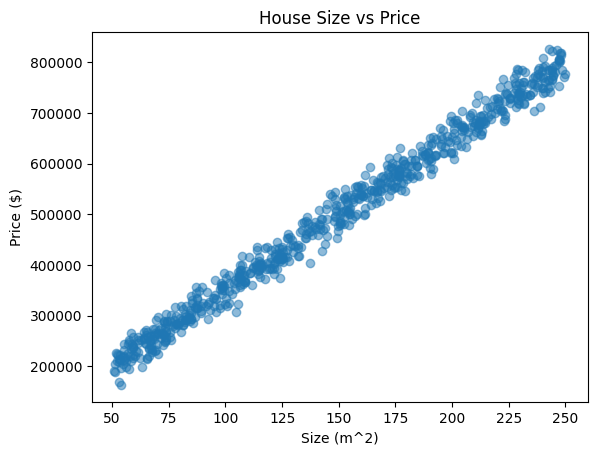

In [ ]:
plt.scatter(df['size_m2'], df['price'], alpha=0.5)  
plt.title('House Size vs Price')  
plt.xlabel('Size (m^2)')  
plt.ylabel('Price ($)') 
plt.show() 


# Linear Regression Variants
We compare several closed-form and iterative linear regression solvers (Normal Equation, SVD, Gradient Descent) alongside scikit-learn's `LinearRegression` on the same synthetic data.


In [ ]:
class LinearRegressionNE:
    def __init__(self):
        self.theta = None 
        self.intercept_ = None  
        self.coef_ = None 

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64) 
        y = np.asarray(y, dtype=np.float64) 
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  
        xtx_inv = np.linalg.inv(X_b.T @ X_b)  
        self.theta = xtx_inv @ X_b.T @ y  
        self.intercept_ = self.theta[0]  
        self.coef_ = self.theta[1:]  

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)  
        return X @ self.coef_ + self.intercept_  

In [ ]:
class LinearRegressionSVD:
    def __init__(self):
        self.theta = None 
        self.intercept_ = None  
        self.coef_ = None  

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)  
        y = np.asarray(y, dtype=np.float64)  
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  
        U, S, Vt = np.linalg.svd(X_b, full_matrices=False)  
        S_inv = np.diag(1 / S)  
        self.theta = Vt.T @ S_inv @ U.T @ y 
        self.intercept_ = self.theta[0] 
        self.coef_ = self.theta[1:]  

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)  
        return X @ self.coef_ + self.intercept_ 

In [ ]:
class LinearRegressionGD:
    def __init__(self, lr=0.01, n_iters=3000):
        self.lr = lr
        self.n_iters = n_iters
        
    def fit(self, X, y):
        X = np.asarray(X).ravel()
        y = np.asarray(y).ravel()

        
        self.x_mean = X.mean()
        self.x_std  = X.std()
        self.y_mean = y.mean()
        self.y_std  = y.std()

        Xs = (X - self.x_mean) / self.x_std    
        ys = (y - self.y_mean) / self.y_std    

        m = len(Xs)

        self.w_ = 0.0
        self.b_ = 0.0

        for _ in range(self.n_iters):

            y_pred = self.w_ * Xs + self.b_

            dw = 0.0
            db = 0.0
            for i in range(m):
                error = y_pred[i] - ys[i]
                dw += error * Xs[i]
                db += error

            dw /= m   
            db /= m

            self.w_ -= self.lr * dw
            self.b_ -= self.lr * db

        self.w = self.w_ * (self.y_std / self.x_std)
        self.b = self.y_mean + self.y_std * self.b_ - self.w * self.x_mean

        self.coef_ = np.array([self.w])
        self.intercept_ = np.array([self.b])

    def predict(self, X):
        X = np.asarray(X).ravel()
        return self.w * X + self.b

In [ ]:
X = df[['size_m2']].values  
y = df['price'].values  

X_train, X_test, y_train, y_test = train_test_split(  
    X, y, test_size=0.2, random_state=42
)  

In [ ]:
models = {
    "Normal Equation": LinearRegressionNE(), 
    "SVD": LinearRegressionSVD(), 
    "Gradient Descent": LinearRegressionGD(lr=0.001, n_iters=1000),  
    "sklearn LinearRegression": LinearRegression()  
}  

results = []  
for name, model in models.items(): 
    model.fit(X_train, y_train)  
    preds = model.predict(X_test)  
    mae = mean_absolute_error(y_test, preds)  
    r2 = r2_score(y_test, preds)  
    intercept = float(np.ravel(model.intercept_)[0]) if hasattr(model, 'intercept_') else np.nan  
    coef = float(np.ravel(model.coef_)[0]) if hasattr(model, 'coef_') else np.nan  
    results.append({  
        "Model": name,
        "Intercept": intercept,
        "Slope": coef,
        "MAE": mae,
        "R2": r2,
        "Intercept-Error": intercept - 50000,
        "Slope-Error": coef - 3000,
    })  
    print(f"{name}: MAE={mae:,.2f}, R^2={r2:.4f}, Intercept={intercept:,.2f}, Slope={coef:,.2f}") 

results_df = pd.DataFrame(results) 
results_df  

Normal Equation: MAE=16,069.32, R^2=0.9872, Intercept=52,796.70, Slope=2,989.46
SVD: MAE=16,069.32, R^2=0.9872, Intercept=52,796.70, Slope=2,989.46
Gradient Descent: MAE=62,144.76, R^2=0.8403, Intercept=218,785.83, Slope=1,890.25
sklearn LinearRegression: MAE=16,069.32, R^2=0.9872, Intercept=52,796.70, Slope=2,989.46


,Model,Intercept,Slope,MAE,R2,Intercept-Error,Slope-Error
0,Normal Equation,52796.704363,2989.458951,16069.324554,0.987185,2796.704363,-10.541049
1,SVD,52796.704363,2989.458951,16069.324554,0.987185,2796.704363,-10.541049
2,Gradient Descent,218785.833461,1890.248572,62144.760137,0.840261,168785.833461,-1109.751428
3,sklearn LinearRegression,52796.704363,2989.458951,16069.324554,0.987185,2796.704363,-10.541049


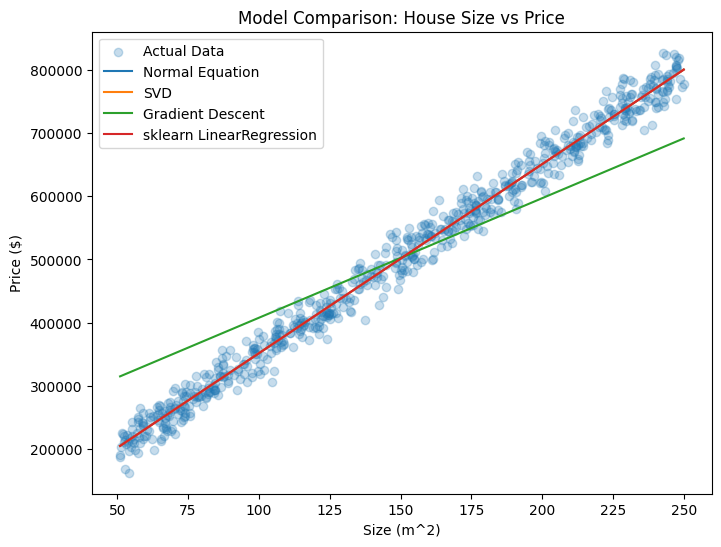

In [ ]:

grid_sizes = np.linspace(df['size_m2'].min(), df['size_m2'].max(), 200).reshape(-1, 1)  
plt.figure(figsize=(8, 6)) 
plt.scatter(df['size_m2'], df['price'], alpha=0.25, label='Actual Data') 
for name, model in models.items():  
    grid_preds = model.predict(grid_sizes)  
    plt.plot(grid_sizes, grid_preds, label=name)  

plt.title('Model Comparison: House Size vs Price') 
plt.xlabel('Size (m^2)')  
plt.ylabel('Price ($)')  
plt.legend()  
plt.show()  